## Preparation of the data

The data that we start with are hundreds of thousands of comments related to some UK hospitals. Each are associated with a label referring to whether the comment is useful (labeled 1) or not (labeled 0) at indicating an effective treatment. I have already cleaned the comments (e.g. small case, punctuation and stop words removed), but I will not share them since the comment/label associations are from private communication.

In this notebook I explore the cleaned comments, and build a meaningful vocabulary of words which will be used for embedding.

To build this vocabulary, I only use 75% of the full sample (i.e. the training sample), and the rest will be used as a test sample. The test sample is not used to build the vocabulary, so that the classifier is tested against words that is not in the vocabulary.

We start by defining a dataframe containing the cleaned comments and their labels, and we calculate the size of the training sample.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties
font0 = FontProperties(family = 'serif', variant = 'small-caps', size = 15)

df = pd.read_csv('../data/efftreat_clean_label.csv')

Ntrain = int(0.75 * len(df))
df = df[:Ntrain]

### Imbalance

As imbalanced data can bias the classifier, we test whether our data are balanced across the positive and negative classes.

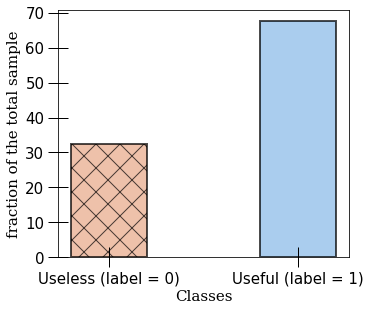

In [2]:
df_balance = df.groupby(['labels'], as_index=False).count()

# Plot the results
fig, axs = plt.subplots(1, 1, figsize = (5, 4))
fig.subplots_adjust(hspace = 0.0, wspace=0., left  = 0.16, right = 0.97, bottom = 0.12, top = 0.98)

axs.bar(['Useless (label = 0)', 'Useful (label = 1)'],
        df_balance['comments_clean'].values/len(df)*100., width = 0.4, hatch = ['X', None],
        edgecolor = 'k', linewidth = 2, color = ['#e8a787','#87b9e8'], alpha = 0.7)

axs.set_ylabel('fraction of the total sample', fontproperties = font0)
axs.set_xlabel('Classes', fontproperties = font0)
axs.tick_params(axis='both', labelcolor='k', labelsize = 15,
                    width = 1, size = 20, which = 'major', direction = 'inout')
axs.tick_params(axis='both', width = 1, size = 10, which = 'minor', direction = 'inout')

This dataset appears to be biased toward positive answers. However, it remains acceptable for the development of the NLP algorithm, since both classes are significantly represented. For the moment, I keep it this way, and this is something we can fix later to improve the performance of the classifier.

### Distribution of words

Let's now have a look at the distribution of words in the comments. To do this, we first rank the top 30 words in terms of popularity (i.e. number of times they appear) for the useful comments (positive class). By doing this, we will get a sense of the words that are key for useful comments.

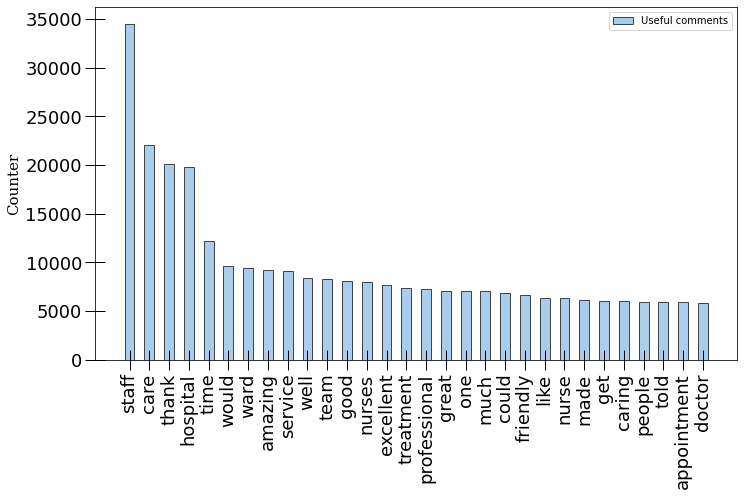

In [3]:
from collections import Counter

df_useful = df.loc[df['labels'] == 1, 'comments_clean'].tolist()

n_word = 30
top_useful = pd.DataFrame(Counter(' '.join(df_useful).split()).most_common(n_word), columns = ['word', 'count'])

# Plot the results
fig, ax1 = plt.subplots(1, 1, figsize = (11, 7))
fig.subplots_adjust(hspace = 0.0, wspace=0., left  = 0.16,
                    right = 0.97, bottom = 0.28, top = 0.98)

ax1.bar(top_useful['word'].values, top_useful['count'].values,
        width = 0.5, edgecolor = 'k', linewidth = 1, color = ['#87b9e8'],
        alpha = 0.7, label = 'Useful comments')
ax1.legend()
ax1.set_ylabel('Counter', fontproperties = font0)
ax1.tick_params(axis='both', labelcolor='k', labelsize = 18,
                width = 1, size = 20, which = 'major', direction = 'inout')
ax1.tick_params(axis='both', width = 1, size = 10, which = 'minor',
                direction = 'inout')
ax1.tick_params(axis = 'x', labelrotation=90)

The words staff, care, thank, hospital... are the top hit in the useful comments. This suggests that they are key for classification, and will have an impact for the learning process of the algorithm. However, it is possible that these words also appear in the useless comments. If this is the case, their predictive power as a single word (1-gram) is null, since they equally weight in both classes.

To test that, we further look at the top popular 30 words which appear in the useless comments, and keep those that are in both the useful and useless classes. We then define a metric which allows us to predict the classification power of the word. The metric is defined as the fraction that a word appears into the positive class, divided by the total fraction of appearance (i.e. positive and negative classes). We further remove 0.5 for normalisation.

Therefore, this metric measures word positivity, and words that fall around a value of 0 equally appears in the useful and useless class, reducing their power of classification.

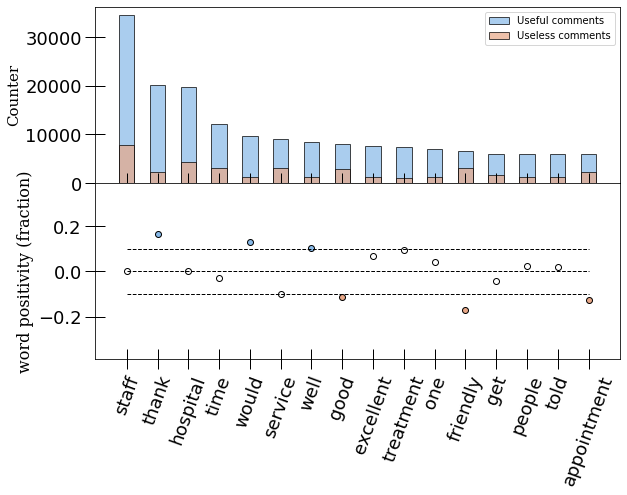

In [4]:
import numpy as np

df_useless = df.loc[df['labels'] == 0, 'comments_clean'].tolist()
top_useless = pd.DataFrame(Counter(' '.join(df_useless).split()).most_common(n_word), columns = ['word', 'count'])

df_word_counter_all = top_useful.merge(top_useless, left_on = 'word',
                                        right_on = 'word', suffixes=('_useful', '_useless'))

# Plot the results
fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize = (9, 7), sharex = True)
fig.subplots_adjust(hspace = 0.0, wspace=0., left  = 0.16,
                    right = 0.97, bottom = 0.28, top = 0.98)

ax1.bar(df_word_counter_all['word'].values,
        df_word_counter_all['count_useful'].values,
        width = 0.5, edgecolor = 'k', linewidth = 1, color = ['#87b9e8'],
        alpha = 0.7, label = 'Useful comments')
ax1.bar(df_word_counter_all['word'].values,
        df_word_counter_all['count_useless'].values,
        width = 0.5, edgecolor = 'k', linewidth = 1, color = ['#e8a787'],
        alpha = 0.7, label = 'Useless comments')

ax1.legend()
ax1.set_ylabel('Counter', fontproperties = font0)
ax1.tick_params(axis='both', labelcolor='k', labelsize = 18,
                width = 1, size = 20, which = 'major', direction = 'inout')
ax1.tick_params(axis='both', width = 1, size = 10,
                which = 'minor', direction = 'inout')

frac_word_useful = df_word_counter_all['count_useful'].values/sum(df_word_counter_all['count_useful'].values)
frac_word_useless = df_word_counter_all['count_useless'].values/sum(df_word_counter_all['count_useless'].values)
word_power = frac_word_useful/(frac_word_useful + frac_word_useless) - 0.5

o_index = np.where((word_power > -0.1) & (word_power < 0.1))[0]
ax2.plot(df_word_counter_all['word'].values[o_index], word_power[o_index], 'o',
         mfc = 'None', mew = 1, mec = 'k')

o_index = np.where((word_power > 0.1))[0]
ax2.plot(df_word_counter_all['word'].values[o_index], word_power[o_index], 'o',
         mfc = '#87b9e8', mew = 1, mec = 'k')

o_index = np.where((word_power < -0.1))[0]
ax2.plot(df_word_counter_all['word'].values[o_index], word_power[o_index], 'o',
         mfc = '#e8a787', mew = 1, mec = 'k')

ax2.plot(df_word_counter_all['word'].values,
         np.zeros(len(df_word_counter_all)), 'k--', lw = 1)
ax2.plot(df_word_counter_all['word'].values,
         np.zeros(len(df_word_counter_all))+0.1, 'k--', lw = 1)
ax2.plot(df_word_counter_all['word'].values,
         np.zeros(len(df_word_counter_all))-0.1, 'k--', lw = 1)
ax2.set_ylim([-0.39, 0.39])
ax2.set_ylabel('word positivity (fraction)', fontproperties = font0, fontsize = 16)
ax2.tick_params(axis='both', labelcolor='k', labelsize = 18,
                width = 1, size = 20, which = 'major', direction = 'inout')
ax2.tick_params(axis='both', width = 1, size = 10, which = 'minor', direction = 'inout')
ax2.tick_params(axis = 'x', labelrotation=70)

This figure shows that the word "staff" heavily appears in both the positive and negative classes, and therefore has very little power of classification. Instead, the word "care" is clearly more present in the positive class, and will probably play a significant role at recognising positive comments. The word "hours" has a low positivity, and clearly appears more in the negative class. Therefore, this word will likely be useful to recognise comments belonging to the negative class. Here, I show an arbitrary cut at 10% to decide whether a word has any classification power.

Because we are still at early stages in terms of developing the NLP algorithm, for the moment, we keep all these words. However, this is definitely something that we will want to go back to at some point to improve the performances of the algorithm.

### Length of the comments

Let's look at how long the comments need to be. In fact, some comments are made of thousands of words, which will results in some heavy embeddings while preparing the comments for ingestion by the NLP algorithm. To avoid unecessary calculation time, we cut the comments to a length which represents that of 90% of the comments.

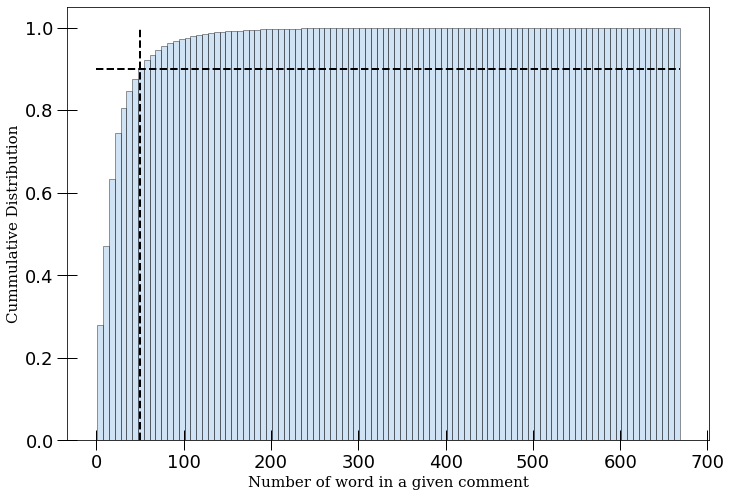

In [5]:
frac_words = 0.90

comments = df['comments_clean'].values
com_length = [len(comment.split(' ')) for comment in comments]
y_val, x_val = np.histogram(com_length, bins = 100)
d_x = (x_val[1:] - x_val[:-1])/2.

y_cumsum = y_val.cumsum()/y_val.cumsum().max()

# To the nearest 10:
comments_length = int(np.round(x_val[0:-1][y_cumsum >= frac_words][0]/10.)*10)

# Plot the resuls
fig, ax1 = plt.subplots(1, 1, figsize = (11, 7))
fig.subplots_adjust(hspace = 0.0, wspace=0., left  = 0.16,
                    right = 0.97, bottom = 0.12, top = 0.98)

ax1.bar(x_val[0:-1] + d_x, y_cumsum, width = d_x*2., edgecolor = 'k',
      linewidth = 1, color = ['#87b9e8'], alpha = 0.4)
ax1.plot([0., x_val[-1]], [frac_words, frac_words], 'k--', lw = 2)
ax1.plot([comments_length, comments_length], [0., 1.], 'k--', lw = 2)
ax1.set_ylabel('Cummulative Distribution', fontproperties = font0)
ax1.set_xlabel('Number of word in a given comment', fontproperties = font0)
ax1.tick_params(axis='both', labelcolor='k', labelsize = 18,
                width = 1, size = 20, which = 'major', direction = 'inout')
ax1.tick_params(axis='both', width = 1, size = 10,
                which = 'minor', direction = 'inout')

90% of the comments are less than 50 words, so we will cut the comments at 50 words maximum.

### Define the vocabulary

To perform NLP we need to define a vocabulary. These are the words that will be transformed into vectors to be ingested by the classifier. For efficiency, we will not use every single words which appear in the comments. Instead, we check which are the most important words (how many time they appear), and select a cut in terms of number of times a word appear so that 90% is selected.

215


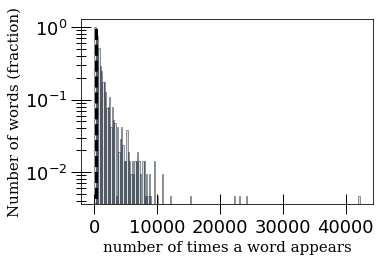

In [9]:
frac_vocab = 0.9
vocab = Counter(' '.join(df['comments_clean']).split())
n_hit_unique = np.unique([val for val in vocab.values()])

y_val, x_val = np.histogram(n_hit_unique, bins = 200)
d_x = (x_val[1:] - x_val[:-1])/2.

n_hit_lim = int(np.interp(frac_vocab, 
                          y_val[::-1].cumsum()/y_val[::-1].cumsum().max(), 
                          (x_val[0:-1] + d_x)[::-1]))

# plot the results
fig, ax1 = plt.subplots(1, 1, figsize = (5, 3))
fig.subplots_adjust(hspace = 0.0, wspace=0., left  = 0.16,
                    right = 0.97, bottom = 0.12, top = 0.98)
ax1.bar(x_val[0:-1] + d_x, y_val/y_val.max(), width = d_x*2., edgecolor = 'k',
      linewidth = 1, color = ['#87b9e8'], alpha = 0.4)
ax1.plot([n_hit_lim, n_hit_lim], [0, 1],  'k--', lw = 3)
ax1.set_ylabel('Number of words (fraction)', fontproperties = font0)
ax1.set_xlabel('number of times a word appears', fontproperties = font0)
ax1.tick_params(axis='both', labelcolor='k', labelsize = 18,
                width = 1, size = 20, which = 'major', direction = 'inout')
ax1.tick_params(axis='both', width = 1, size = 10,
                which = 'minor', direction = 'inout')
ax1.set_yscale('log')

print(n_hit_lim)

Few words appear more than 40000 times, and a lot more only one time. The words appearing one time will likely not play a big role into the classification, and therefore have very little classification power. After ranking the words by importance, if we select the words that appear more than 215 times, we catch 90% of the most important words, where importance is measured by the number of times a word appears. This corresponds to 1405 individual words in the vocabulary.

In [10]:
n_hit = np.array([val for val in vocab.values()])
word = np.array([key for key in vocab])
word_in_vocab = sorted(word[n_hit > n_hit_lim])

print("The first 10 words of our vocabulary are:")
print(word_in_vocab[0:10])

The first 10 words of our vocabulary are:
['able', 'about', 'absolute', 'absolutely', 'access', 'accident', 'across', 'action', 'actual', 'actually']


### Concluding remarks

Throughout this notebook I show some pre-treatment steps that we can take in an attempt to improve the classification of our comments. Because this is early stage, I simply point out some of the potential areas that we can work on to try and improve the pre-treatment of the comments. Once the NLP algorithm will be better defined, we can come back to the pre-treatment of the data, and try to improve things such as the imbalance of the data, or select words with better classification power. I further define a vocabulary of words which will then be used to transform the comments into vectors.